In [1]:
import plotly.express as px
import glob
import pandas as pd
import numpy as np
import importlib
import seaborn as sns
import plotting_utils as pu

In [ ]:
importlib.reload(pu)

NameError: name 'nib' is not defined

In [6]:
def get_df_list_from_pattern(base, pattern):
    return glob.glob(f"{base}/{pattern}")


def get_df_list_from_list(measure, base, pre, post):
    assert len(pre) == len(pro)
    suffix=[f"{pre[i]}/{measure}_{post[i]}.tsv" for i in range(len(pre))]
    return [base + model for model in suffix]


def removeprefix(x, prefix):
    a = len(prefix)
    return x[a:] if x[:a] == prefix else x


def combine_left_right_structures(df, group=["SubjectName", "Net_type", "Structures", "SF"]):
    df["Hemi"] = df["Structures"].apply(lambda x: x.split("-")[0] if x.split("-")[0] in ["Left", "Right"] else "Unilateral")
    try:
        df["Structures"] = df["Structures"].str.removeprefix("Left-")
        df["Structures"] = df["Structures"].str.removeprefix("Right-")
    except AttributeError:
        print("Python version too old. Removeprefix was introduced in python3.9.")
        df["Structures"] = df["Structures"].apply(lambda x: removeprefix(x, prefix="Left-"))
        df["Structures"] = df["Structures"].apply(lambda x: removeprefix(x, prefix="Right-"))
    if "dice" in df.columns:
        df["dice"] = pd.to_numeric(df.dice, errors='coerce')
    elif "surfaceAverageHausdorff" in df.columns:
        df["surfaceAverageHausdorff"] = pd.to_numeric(df.surfaceAverageHausdorff, errors='coerce')
    return df[df.columns[df.columns!='Hemi']].groupby(group).agg("median").reset_index()


def aug_split(row):
    split = row.split("-")
    if len(split) > 5:
        return split[5] if split[5] != "full" else "NoAug"
    else:
        return "NoAug"
    
def view_split(row):
    split = row.split("-")
    check_idx = -3 if split[-2] == "t2" else -2
    pot_view = split[check_idx]
    return pot_view if pot_view in ["axial", "coronal", "sagittal"] else "all"
    

def get_res_from_name(df, single=False):
    """
    New split: Split 
    ['ValSet', 'FastSurferDDB', 'Infant', 'bigMix', 'T1T2', 'ScaleArtefact', 'AdamW', 'Cos', '3x3F', '71', 
       0            1 = net       2           3       4        (5 = Aug)         6      7      8       9
     '1.0BR', 'full', 'coronal', 't2', 'image']
    10/-3 = BR (11)      (12)     13/-2 = Modal
    
    ValidationSet:
    [ValidationSet, FastSurferCNN, T1T2, 05, T1, RotTLScale, full]
        0.              1           2    3    4   (5)        (6) 
    """

    if single:
        df["Res"] = df["SF"].astype(str)
        df["NetMode"] = df["Net_type"].str.split("-").str[4]
        df["Mode"] = df["Net_type"].apply(lambda x: "T2" if x.split("-")[-2] == "t2" else "T1")
        df["Aug"] = df["Net_type"].apply(lambda x: x.split("-")[5] if x.split("-")[5] != "AdamW" else "NoAug")
        df["LabelSet"] = df["Net_type"].apply(lambda x: "Full" if "full" in x.split("-") else "Mapped")
        df["View"] = df["Net_type"].apply(lambda x: view_split(x))
    
    else:
        df["Res"] = df["Net_type"].str.split("-").str[3]
        df["Mode"] = df["Net_type"].str.split("-").str[4]
        df["NetMode"] = df["Net_type"].str.split("-").str[2]
        df["Aug"] = df["Net_type"].apply(lambda x: aug_split(x))
        df["LabelSet"] = df["Net_type"].apply(lambda x: "Full" if "full" in x.split("-") else "Mapped")
        df["View"] = df["Net_type"].apply(lambda x: x.split("-")[-1] if x.split("-")[-1] != "full" else "all")
        
    df["Net"] = df["Net_type"].str.split("-").str[1]
    df["NetOnPredMode"] = df["NetMode"] + " on " + df["Mode"]
    df["TrainRes"] = df["Net_type"].str.split("-").str[0]
    df["Net_type"] = df["Net"] + "_" + df["Aug"] + "_" + df["NetMode"]
    

    return df

def add_gaussian(df, network, measure, suffix="-ExtAug", change=[0.005, 0.01]):
    m_new = df[df["Net_type"] == network]
    if measure == "dice":
        m_new[measure] += np.random.normal(change[0], change[1], size = m_new[measure].values.shape)
    elif measure == "surfaceAverageHausdorff":
        m_new[measure] -= np.random.normal(change[0], change[1], size = m_new[measure].values.shape)
    m_new["Net_type"] = network + suffix
    df = df.append(m_new, ignore_index=True)
    return df
    
def plot_metrics(base, measure, single_view=False, net_type="SF", pattern=None, pre=None, post=None, 
                 networks="all", baseres="all", res="all", struct="all", combine_lr=True):
    # get all metric files
    if pattern is None:
        metric_list = get_df_list_from_list(measure, base, pre, post)
    else:
        metric_list = get_df_list_from_pattern(base, pattern)
    print(metric_list)
    # combine to df
    m_all = pu.combine_dfs(metric_list, measure, net_type)

    for model in m_all[net_type[0]]:
        if isinstance(model, float):
            print(model)
    m_all["Net_type"] = m_all[net_type[0]].apply(lambda x: "-".join(x.split("_")))
    if combine_lr:
        print(m_all.columns)
        m_all = combine_left_right_structures(m_all)
        print(m_all.columns)
    m_all = get_res_from_name(m_all, single_view)

    if baseres != "all":
        m_all = m_all[m_all["BaseRes"] == baseres]
        
    if res != "all":
        m_all = m_all[m_all["Res"] == res]
        
    if struct != "all":
        print(np.unique(m_all["Structures"]))
        m_all = m_all[m_all["Structures"].isin(struct)]
    
    if networks != "all":
        m_all = m_all[m_all["Net_type"].isin(networks)]
    
    """
    m_all = add_gaussian(m_all, "FastSurferDDB-dHCP", suffix="+RA", measure=measure, change=[-0.008, 0.01])
    m_all = add_gaussian(m_all, "FastSurferDDB-dHCP", suffix="+BF", measure=measure, change=[-0.01, 0.01])
    m_all = add_gaussian(m_all, "FastSurferDDB-dHCP", suffix="+TL", measure=measure, change=[0.00005, 0.0001])
    m_all = add_gaussian(m_all, "FastSurferDDB-dHCP", suffix="+Rot", measure=measure, change=[0.005, 0.001])
    m_all = add_gaussian(m_all, "FastSurferDDB-dHCP", suffix="+SC", measure=measure, change=[0.0006, 0.0001])
    """
    return m_all

In [7]:
pre_d = ["FastSurferVINN_net1/eval_metrics","FastSurfer_net1/eval_metrics", "FastSurfer_net1/eval_metrics"]
post_d = ["ValSet_FastSurferVINN_coronal",
        "ValSet_FastSurferCNN_coronal",
        "ValSet_FastSurferCNN_RotTLScale_coronal"]

In [8]:
based="/groups/ag-reuter/projects/master-theses/henschell"#"/autofs/vast/lzgroup/Projects/"

In [11]:
base_dir = based + "/FastInfantSurfer/experiments"
#base_dir = "/groups/ag-reuter/projects/datasets/MCRIB/VINN"
metric = "dice" #"surfaceAverageHausdorff" #
dsc_pattern = f"eval_metrics/{metric}_TestingSet_nnUNet2D_T*_full.tsv" 
#_*T2_05_T2*_full_mapped.tsv"# TestingSet_FastSurferVINN_T2_*_T[1-2]_LatentAug*_full.tsv" 
#  DebugAffineNN DebugDSAffine
#f"*_net1/eval_metrics/{metric}_*vinn*.tsv" 
#[!(coronal)].tsv" _TestingSet_* 
# TestingSet_FastSurfer*INN_T2_*_T2_*full.tsv
# _ValidationSet_FastSurfer*_T2_*_T2*_full.tsv *_Infant_bigMix_*_full_axial_t2_image.tsv
net_sel = ["FastSurferVINN-dHCP",  
           "FastSurferDDB-dHCP", 
           "RCVNet-dHCP-T1",
           "RCVNet-dHCP-T1-CosWR",
           "FastSurferVINN-dHCP-T2",  
           "FastSurferDDB-dHCP-T2",
           "RCVNet-dHCP-T2",
           "RCVNet-dHCP-T2-CosWR"]

net_sel = ["FastSurferVINN-dHCP",
           "FastSurferVINN-dHCP-hires-08mm", 
           "FastSurferVINN-dHCP-hires-07mm",
           "FastSurferVINN-dHCP-hires-06mm",
           "FastSurferDDB-dHCP-RotTLScale",
           "FastSurferDDB-dHCP-RotTLScale-hires-08mm", 
           "FastSurferDDB-dHCP-RotTLScale-hires-07mm",
           "FastSurferDDB-dHCP-RotTLScale-hires-06mm",]

net_sel = ["FastSurferDDB-big-dHCP-T1",
           "new-FastSurferDDB-dHCP-T1",
           "FastSurferVINN-big-dHCP-T1",
           "new-FastSurferVINN-dHCP-T1",
           "FastSurferDDB-big-dHCP-T2",
           "new-FastSurferDDB-dHCP-T2",
           "FastSurferVINN-big-dHCP-T2",
           "new-FastSurferVINN-dHCP-T2"]

net_sel=["svinn-08-T1",
           "vinn-08-T1",
           "svinn-08-T2",
           "vinn-08-T2"]

net_sel=["FastSurferVINN_NoAug_T1", "FastSurferVINN_LatentAug_T1",
         "FastSurferVINN_NoAug_T2", "FastSurferVINN_LatentAug_T2",
         "FastSurferVINN_NoAug_T1T2", "FastSurferVINN_LatentAug_T1T2",
         "FastSurferSVINN_NoAug_T1T2", "FastSurferSVINN_LatentAug_T1T2",
        ]
net_sel="all"
var_cols = ["Net_type", "SubjectName", "SF"] # Net_type Must be first!!
struct="all" #["Average", "Cerebral-Cortex", "Subcortical", "Cerebral-White-Matter"]

#net_sel = ["RCVNet-dHCP", "RCVNet-dHCP-LatentAug"]
# get dsc_list with one of the methods defined above
dsc_df = plot_metrics(base_dir, metric, single_view=False, net_type=var_cols, pattern=dsc_pattern,
                      networks=net_sel, baseres="all", res="all", struct=struct)
dsc_df.tail()

['/groups/ag-reuter/projects/master-theses/henschell/FastInfantSurfer/experiments/eval_metrics/dice_TestingSet_nnUNet2D_T2_10_T2_full.tsv', '/groups/ag-reuter/projects/master-theses/henschell/FastInfantSurfer/experiments/eval_metrics/dice_TestingSet_nnUNet2D_T2_05_T2_full.tsv', '/groups/ag-reuter/projects/master-theses/henschell/FastInfantSurfer/experiments/eval_metrics/dice_TestingSet_nnUNet2D_T2_08_T2_full.tsv', '/groups/ag-reuter/projects/master-theses/henschell/FastInfantSurfer/experiments/eval_metrics/dice_TestingSet_nnUNet2D_T1_05_T1_full.tsv', '/groups/ag-reuter/projects/master-theses/henschell/FastInfantSurfer/experiments/eval_metrics/dice_TestingSet_nnUNet2D_T1_08_T1_full.tsv', '/groups/ag-reuter/projects/master-theses/henschell/FastInfantSurfer/experiments/eval_metrics/dice_TestingSet_nnUNet2D_T1_10_T1_full.tsv']
Read dataframe - Shape: (107, 99), Name: TestingSet_nnUNet2D_T2_10_T2_full
Subcortical Average
DSC times 100
Read dataframe - Shape: (107, 99), Name: TestingSet_nnUN

,SubjectName,Net_type,Structures,SF,dice,Res,Mode,NetMode,Aug,LabelSet,View,Net,NetOnPredMode,TrainRes
32227,sub-CC01234AN14_ses-155030,nnUNet2D_NoAug_T2,Superior_temporal_gyrus_posterior_part_GM,1.0,79.562625,10,T2,T2,NoAug,Full,all,nnUNet2D,T2 on T2,TestingSet
32228,sub-CC01234AN14_ses-155030,nnUNet2D_NoAug_T2,Superior_temporal_gyrus_posterior_part_WM,1.0,88.021592,10,T2,T2,NoAug,Full,all,nnUNet2D,T2 on T2,TestingSet
32229,sub-CC01234AN14_ses-155030,nnUNet2D_NoAug_T2,Thalamus,1.0,94.746771,10,T2,T2,NoAug,Full,all,nnUNet2D,T2 on T2,TestingSet
32230,sub-CC01234AN14_ses-155030,nnUNet2D_NoAug_T2,Thalamus_high_intensity_part_in_T2,1.0,93.663674,10,T2,T2,NoAug,Full,all,nnUNet2D,T2 on T2,TestingSet
32231,sub-CC01234AN14_ses-155030,nnUNet2D_NoAug_T2,Thalamus_low_intensity_part_in_T2,1.0,83.303571,10,T2,T2,NoAug,Full,all,nnUNet2D,T2 on T2,TestingSet


In [85]:
#dsc_df_rot["Run"] = dsc_df_rot["TrainRes"].apply(lambda x: x[len("DebugAffineNN"):].title())
#dsc_df = pd.concat([dsc_df_rot, dsc_df_all])
print(np.unique(dsc_df_svinn["Res"]))
dsc_df_svinn.head()

['05' '08' '08NN05' '08from10' '08to05' '10' '10NN05' '10NN08' '10to05'
 '10to08']


,SubjectName,Net_type,Structures,SF,dice,Res,Mode,NetMode,Aug,LabelSet,View,Net,NetOnPredMode,TrainRes
0,sub-CC00051XX02_ses-7702,FastSurferSVINN_LatentAug_T2,Amygdala,0.5,93.703295,08to05,T2,T2,LatentAug,Full,all,FastSurferSVINN,T2 on T2,TestingSet
1,sub-CC00051XX02_ses-7702,FastSurferSVINN_LatentAug_T2,Anterior_temporal_lobe_lateral_part_GM,0.5,86.926125,08to05,T2,T2,LatentAug,Full,all,FastSurferSVINN,T2 on T2,TestingSet
2,sub-CC00051XX02_ses-7702,FastSurferSVINN_LatentAug_T2,Anterior_temporal_lobe_lateral_part_WM,0.5,86.597061,08to05,T2,T2,LatentAug,Full,all,FastSurferSVINN,T2 on T2,TestingSet
3,sub-CC00051XX02_ses-7702,FastSurferSVINN_LatentAug_T2,Anterior_temporal_lobe_medial_part_GM,0.5,90.154901,08to05,T2,T2,LatentAug,Full,all,FastSurferSVINN,T2 on T2,TestingSet
4,sub-CC00051XX02_ses-7702,FastSurferSVINN_LatentAug_T2,Anterior_temporal_lobe_medial_part_WM,0.5,89.198556,08to05,T2,T2,LatentAug,Full,all,FastSurferSVINN,T2 on T2,TestingSet


In [217]:
dsc_df = pd.concat([dsc_df_rot, subset])

In [92]:
dsc_df["Resolution [mm]"] = dsc_df["Res"].apply(lambda x: 0.5 if x == "05" else 0.8 if x == "08" else 1.0 if x == "10" else 1.6)

,SubjectName,Net_type,Structures,SF,dice,Res,Mode,NetMode,Aug,LabelSet,View,Net,NetOnPredMode,TrainRes,Resolution [mm],surfaceAverageHausdorff
0,sub-CC00057XX08_ses-11002,FastSurferVINN_LatentAug_T2,Amygdala,1.6,80.825505,16,T2,T2,LatentAug,Full,all,FastSurferVINN,T2 on T2,ValidationSet,1.6,NaN
1,sub-CC00057XX08_ses-11002,FastSurferVINN_LatentAug_T2,Anterior_temporal_lobe_lateral_part_GM,1.6,71.354376,16,T2,T2,LatentAug,Full,all,FastSurferVINN,T2 on T2,ValidationSet,1.6,NaN
2,sub-CC00057XX08_ses-11002,FastSurferVINN_LatentAug_T2,Anterior_temporal_lobe_lateral_part_WM,1.6,65.433228,16,T2,T2,LatentAug,Full,all,FastSurferVINN,T2 on T2,ValidationSet,1.6,NaN
3,sub-CC00057XX08_ses-11002,FastSurferVINN_LatentAug_T2,Anterior_temporal_lobe_medial_part_GM,1.6,69.228307,16,T2,T2,LatentAug,Full,all,FastSurferVINN,T2 on T2,ValidationSet,1.6,NaN
4,sub-CC00057XX08_ses-11002,FastSurferVINN_LatentAug_T2,Anterior_temporal_lobe_medial_part_WM,1.6,67.375042,16,T2,T2,LatentAug,Full,all,FastSurferVINN,T2 on T2,ValidationSet,1.6,NaN


In [50]:
def net_definition(net, res):
    if net == "FastSurferVINN":
        if res[2:4] == "NN":
            return "VINN + NN Interpol"
        elif res[2:4] == "to":
            return "VINN + Softmax Interpol"
        else:
            return "VINN + Image Interpol"
    else:
        return "SVINN + SuperRes"
    
def res_to_res(res):
    inres, outres = res[:2], res[-2:]
    if len(res) > 2 and res[2] == "f":
        #print(res, inres, outres)
        return f"{outres[0]}.{outres[1]} to {inres[0]}.{inres[1]}"
    else:
        return f"{inres[0]}.{inres[1]} to {outres[0]}.{outres[1]}"
    
    
df["Net + Interpolation"] = df.apply(lambda x: net_definition(x["Net"], x["Res"]), axis=1)
df["From -> To [Resolution, mm]"] = df.apply(lambda x: res_to_res(x["Res"]), axis=1)

In [51]:
df["Structures"] = df["Structures"].apply(lambda x: "Cortex" if x=="Cerebral-Cortex" else "White Matter" if x=="Cerebral-White-Matter" else x)
np.unique(df["From -> To [Resolution, mm]"])
print(df.columns)

Index(['SubjectName', 'Net_type', 'Structures', 'SF', 'dice', 'Res', 'Mode',
       'NetMode', 'Aug', 'LabelSet', 'View', 'Net', 'NetOnPredMode',
       'TrainRes', 'Net + Interpolation', 'From -> To [Resolution, mm]'],
      dtype='object')


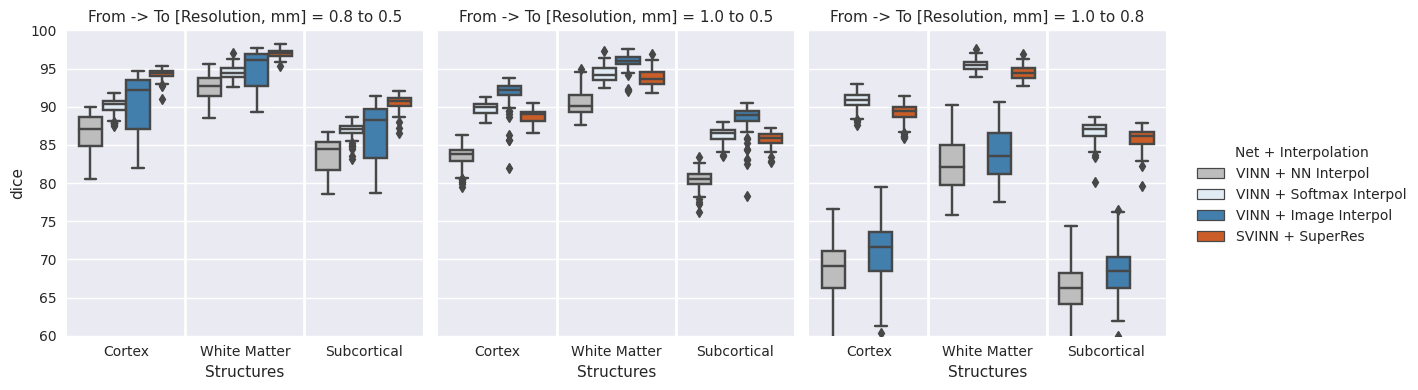

In [53]:
resi=['08NN05','08to05', '10NN05', '10NN08', '10to05', '10to08', '05from10', '05from08', '08from10']#["05", "08", "10"]
struct=["Cortex", "White Matter", "Subcortical"]#["Cerebral-Cortex", "Cerebral-White-Matter", "Subcortical"]
filternet=  (df["Res"].isin(resi)) & (df["Structures"].isin(struct)) #"Hippocampus", "Amygdala"])) #
#  (dsc_df["Res"].isin(["05", "08", "10"])) &  & (dsc_df["Aug"] == "NoAug")
 # & (dsc_df["SubjectName"] == "sub-CC00189XX17_ses-62301") (dsc_df["Net"].isin(["FastSurferDDB"]))  & 
#dsc_df["Combi"] = dsc_df["N"] + " " + dsc_df["Net"] + " " + dsc_df["Aug"] 

pal1 = ["#f0f0f0",  "#018571",  "#80cdc1", "#fdb863", "#e66101", "#5e3c99", "#bdbdbd", "#b2abd2" ]
pal2 = ["#bdbdbd", 
        "#deebf7", "#3182bd",  # "#9ecae1", #"#bdbdbd", 
        "#e6550d", # left, "#fee6ce", middle: "#fdae6b", 
        "#f0f0f0", "#bdbdbd", "#636363"]
boxp = sns.catplot(data=df[filternet], x="Structures", y=metric, 
                   hue="Net + Interpolation", col="From -> To [Resolution, mm]", #col_wrap=5,
                   palette=pal2, 
                   sharey=True, #errcolor='gray',
                   #errwidth=1, capsize=0.05,
                   hue_order=["VINN + NN Interpol", "VINN + Softmax Interpol", "VINN + Image Interpol", "SVINN + SuperRes"],#"ibeat_NoAug_T2", 
                   #           "FS_NoAug_T1",
                   #           "nnUNet2D_NoAug_T1", "nnUNet3D_NoAug_T1",  
                   #           "FastSurferDDB_RotTLScale_T1", #"All FastSurferDDB NoAug", 
                              #"FastSurferVINN_RotTLScale_T1", 
                   #           "FastSurferVINN_LatentAug_T1", 
                    #         ],
                   #col_wrap=5, #hue_order=net_sel,
                   kind="box", legend_out=True, height=4, aspect=1)
boxp.set(ylim=(60, 100))
#boxp.set(ylim=(0, 0.8))
#boxp.set_xticklabels(rotation=30)

for line in [0.5, 1.5]:#, 2.5, 3.5, 4.5]:
    boxp.refline(x=line, color = "white", lw = 2, linestyle='-')
   
for ax in boxp.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()):.1f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge', padding=0)
    ax.margins(y=0.2)


boxp.figure.savefig(base_dir + "/figures/fig7_t2_superres_dsc.svg")



In [468]:
filtered = asd_df[filternet]
np.unique(filtered["Net_type"])

array(['FS_NoAug_T1', 'FastSurferCNN_RotTLScale_T1',
       'FastSurferCNN_RotTLScale_T1T2', 'FastSurferCNN_RotTLScale_T2',
       'FastSurferDDB_NoAug_T1', 'FastSurferDDB_NoAug_T2',
       'FastSurferDDB_RotTLScale_T1', 'FastSurferDDB_RotTLScale_T2',
       'FastSurferVINN_LatentAug_T1', 'FastSurferVINN_LatentAug_T2',
       'FastSurferVINN_NoAug_T1', 'FastSurferVINN_NoAug_T2',
       'FastSurferVINN_RotTLScale_T1', 'FastSurferVINN_RotTLScale_T2',
       'ibeat_NoAug_T2', 'nnUNet2D_NoAug_T1', 'nnUNet2D_NoAug_T2',
       'nnUNet3D_NoAug_T1', 'nnUNet3D_NoAug_T2', 'nnUNet_NoAug_T1T2'],
      dtype=object)

In [15]:
def category_age(row):
    if row < 32:
        return "<32"
    if row < 36:
        return "<36"
    elif row < 40:
        return "<40"
    elif row < 46:
        return "<46"
    else:
        return "<47"

In [16]:
filtered = df_val
meta = pd.read_csv(based + "/FastInfantSurfer/data/dataset_split_large_testing_t1t2_meta.tsv", 
                   sep="\t")
# merge on subject to get age information
meta.head()
#filtered.head()
filtered_meta = filtered.merge(meta, how="left", left_on="SubjectName", right_on="SubjectFix")
filtered_meta["scan_group"] = filtered_meta["scan_age"].apply(lambda x: category_age(x))
np.unique(filtered_meta["Net"], return_counts=True)

(array(['nnUNet2D'], dtype=object), array([32232]))

In [163]:
np.unique(filtered_meta["Net_type"], return_counts=True)
filtered_meta.columns

Index(['SubjectName', 'Net_type', 'Structures', 'DSC', 'Res', 'Mode', 'Aug',
       'Net', 'ASD [mm]', 'Resolution [mm]', 'Path', 'SubjectFix', 'scan_age',
       'sex', 'scan_group'],
      dtype='object')

In [ ]:
filtered_meta[(filtered_meta["Net_type"] == "nnUNet3D_NoAug_T1") & (filtered_meta["Structures"] == "Subcortical")]

In [359]:
filtered_meta[filtered_meta["Net_type"] == "FastSurferVINN_RotTLScale_T1"].head()

,SubjectName,Net_type,Structures,SF,dice,Res,Mode,NetMode,Aug,LabelSet,...,Net,NetOnPredMode,TrainRes,Resolution [mm],Path,SubjectFix,scan_age,sex,Resolution,scan_group
99,sub-CC00057XX08_ses-11002,FastSurferVINN_RotTLScale_T1,Cerebral-Cortex,0.5,86.760948,05,T1,T1,RotTLScale,Full,...,FastSurferVINN,T1 on T1,ValidationSet,0.5,/autofs/vast/lzgroup/Projects/FastInfantSurfer...,sub-CC00057XX08_ses-11002,41.29,female,0.5,<46
100,sub-CC00057XX08_ses-11002,FastSurferVINN_RotTLScale_T1,Cerebral-White-Matter,0.5,89.518914,05,T1,T1,RotTLScale,Full,...,FastSurferVINN,T1 on T1,ValidationSet,0.5,/autofs/vast/lzgroup/Projects/FastInfantSurfer...,sub-CC00057XX08_ses-11002,41.29,female,0.5,<46
101,sub-CC00057XX08_ses-11002,FastSurferVINN_RotTLScale_T1,Subcortical,0.5,82.737593,05,T1,T1,RotTLScale,Full,...,FastSurferVINN,T1 on T1,ValidationSet,0.5,/autofs/vast/lzgroup/Projects/FastInfantSurfer...,sub-CC00057XX08_ses-11002,41.29,female,0.5,<46
108,sub-CC00057XX08_ses-11002,FastSurferVINN_RotTLScale_T1,Cerebral-Cortex,0.8,86.295373,08,T1,T1,RotTLScale,Full,...,FastSurferVINN,T1 on T1,ValidationSet,0.8,/autofs/vast/lzgroup/Projects/FastInfantSurfer...,sub-CC00057XX08_ses-11002,41.29,female,0.5,<46
109,sub-CC00057XX08_ses-11002,FastSurferVINN_RotTLScale_T1,Cerebral-White-Matter,0.8,89.724119,08,T1,T1,RotTLScale,Full,...,FastSurferVINN,T1 on T1,ValidationSet,0.8,/autofs/vast/lzgroup/Projects/FastInfantSurfer...,sub-CC00057XX08_ses-11002,41.29,female,0.5,<46


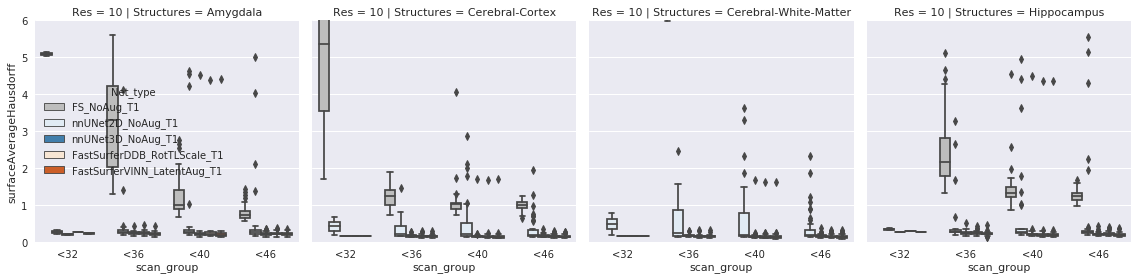

In [475]:
import seaborn as sns

boxp = sns.catplot(data=filtered_meta[filtered_meta["Res"] == "10"], x="scan_group", y=metric, 
                   hue="Net_type", col="Structures", order=["<32", 
                       "<36", "<40", "<46"],
                   palette=pal2, #[ "#a6611a", "#dfc27d", "#018571", "#80cdc1"],
                   row="Res", hue_order=[#"ibeat_NoAug_T2", 
                              "FS_NoAug_T1",
                              "nnUNet2D_NoAug_T1", "nnUNet3D_NoAug_T1",  
                              "FastSurferDDB_RotTLScale_T1", #"All FastSurferDDB NoAug", 
                              #"FastSurferVINN_RotTLScale_T1", 
                              "FastSurferVINN_LatentAug_T1", 
                             ],#hue_order=["nnUNet", "FastSurferCNN", "FastSurferVINN"],
                   kind="box", legend_out=False, height=4, aspect=1.0)
boxp.set(ylim=(0, 6))
boxp.figure.savefig(base_dir + "/figures/fig4_t1_infantage_asd.svg")

In [12]:
drop_col = ["SF", "NetMode", "LabelSet", "View", "NetOnPredMode", 
            "TrainRes"]

#df_val = dsc_df_val.drop(drop_col, axis=1).merge(asd_df_val.drop(drop_col,
#                                                                 axis=1), how="left", 
#                                                 on=["SubjectName", "Res",
#                                                     "Structures", "Mode",
#                                                     "Net_type", "Net", 
#                                                     "Aug"])

df_val = dsc_df.drop(drop_col, 
                           axis=1).merge(asd_df.drop(drop_col, 
                                                          axis=1), 
                                         how="left", 
                                         on=["SubjectName", "Res", 
                                             "Structures", "Mode", 
                                             "Net_type", "Net", "Aug"])
df_val.columns
print(np.unique(df_val["Net"]))
print(np.unique(df_val["Net_type"]))
df_val.head()



['nnUNet2D']
['nnUNet2D_NoAug_T1' 'nnUNet2D_NoAug_T2']


,SubjectName,Net_type,Structures,dice,Res,Mode,Aug,Net,surfaceAverageHausdorff
0,sub-CC00051XX02_ses-7702,nnUNet2D_NoAug_T1,Amygdala,62.164851,05,T1,NoAug,nnUNet2D,7.898522
1,sub-CC00051XX02_ses-7702,nnUNet2D_NoAug_T1,Anterior_temporal_lobe_lateral_part_GM,79.730639,05,T1,NoAug,nnUNet2D,0.445900
2,sub-CC00051XX02_ses-7702,nnUNet2D_NoAug_T1,Anterior_temporal_lobe_lateral_part_WM,80.658276,05,T1,NoAug,nnUNet2D,0.541302
3,sub-CC00051XX02_ses-7702,nnUNet2D_NoAug_T1,Anterior_temporal_lobe_medial_part_GM,83.276006,05,T1,NoAug,nnUNet2D,0.429433
4,sub-CC00051XX02_ses-7702,nnUNet2D_NoAug_T1,Anterior_temporal_lobe_medial_part_WM,81.906991,05,T1,NoAug,nnUNet2D,0.578749


In [126]:
print(np.unique(df_val["Net_type"]))

['FastSurferCNN_NoAug_T1' 'FastSurferCNN_NoAug_T2'
 'FastSurferCNN_RotTLScale_T1' 'FastSurferCNN_RotTLScale_T2'
 'FastSurferDDB_NoAug_T1' 'FastSurferDDB_NoAug_T2'
 'FastSurferDDB_RotTLScale_T1' 'FastSurferDDB_RotTLScale_T2'
 'FastSurferVINN_LatentAugRotTLScale_T1'
 'FastSurferVINN_LatentAugRotTLScale_T2' 'FastSurferVINN_LatentAug_T1'
 'FastSurferVINN_LatentAug_T2' 'FastSurferVINN_NoAug_T1'
 'FastSurferVINN_NoAug_T2' 'FastSurferVINN_RotTLScale_T1'
 'FastSurferVINN_RotTLScale_T2']


In [13]:
#net_sel = ["ibeat", "nnUNet2D", "nnUNet3D", "FS", "CNN + extAug", "VINN + intAug"]
#net_sel = ["ibeat", "nnUNet2D", "nnUNet3D", "VINNA", "VINNA + Aug", "dhcp"] #, "VINNA + SynthMix", "VINNA + SynthFull"]
#net_sel = ["CNN + extAug", "VINN + extAug", "VINN + intAug"]#, "VINN + intAug + extAug"]
net_sel = ["nnUNet2D"]

def name_mappings(x):
    if x[:-3] == "FastSurferDDB_RotTLScale":
        newname = "CNN + extAug" 
    elif x[:-3] == "FastSurferVINN_LatentAugPlus":
        newname = "VINNA + Aug"
    elif x[:-3] == "FastSurferVINN_LatentAugPlusSynthSegFull":
        newname = "VINNA + SynthFull"
    elif x[:-3] == "FastSurferVINN_LatentAugPlusSynthSegMix":
        newname = "VINNA + SynthMix"
    elif x[:-3] == "FastSurferVINN_LatentAug":
        newname = "VINN + intAug"   
    elif x[:-3] == "FastSurferVINN_LatentAugRotTLScale":
        newname = "VINN + intAug + extAug"
    elif x[:-3] == "FastSurferVINN_RotTLScale":
        newname = "VINN + extAug"
    elif x[:2] == "FS":
        newname = "infantFS" 
    else:
        newname = x.split("_")[0]
    return newname

df_val["Structures"] = df_val["Structures"].apply(lambda x: "Cortex" if x=="Cerebral-Cortex" else "White Matter" if x=="Cerebral-White-Matter" else x)
df_val["Resolution [mm]"] = df_val["Res"].apply(lambda x: 0.5 if x == "05" else 0.8 if x == "08" else 1.0 if x =="10" else 1.6 if x =="16" else 0.0)
df_val.rename({"dice": "DSC", "surfaceAverageHausdorff": "ASD [mm]", "scan_group": "age [weeks]"}, inplace=True, axis=1)
df_val["Net"] = df_val["Net_type"].apply(lambda x: name_mappings(x))
df_val = df_val[(df_val["Net"].isin(net_sel))] #\
#                 & (df_val["Resolution [mm]"].isin([0.5, 0.8,1.0])))]
df_val.columns
#test = df_val[df_val["Net"] =="CNN + extAug"]
#print(np.unique(test["Resolution [mm]"], return_counts=True))
print(np.unique(df_val["Structures"], return_counts=True))
df_val.head()


(array(['Amygdala', 'Anterior_temporal_lobe_lateral_part_GM',
       'Anterior_temporal_lobe_lateral_part_WM',
       'Anterior_temporal_lobe_medial_part_GM',
       'Anterior_temporal_lobe_medial_part_WM', 'Average', 'Brainstem',
       'CSF', 'Caudate_nucleus', 'Cerebellum',
       'Cingulate_gyrus_anterior_part_GM',
       'Cingulate_gyrus_anterior_part_WM',
       'Cingulate_gyrus_posterior_part_GM',
       'Cingulate_gyrus_posterior_part_WM', 'Corpus_Callosum', 'Cortex',
       'Extra_cranial_background', 'Frontal_lobe_GM', 'Frontal_lobe_WM',
       'Gyri_parahippocampalis_et_ambiens_anterior_part_GM',
       'Gyri_parahippocampalis_et_ambiens_anterior_part_WM',
       'Gyri_parahippocampalis_et_ambiens_posterior_part_GM',
       'Gyri_parahippocampalis_et_ambiens_posterior_part_WM',
       'Hippocampus', 'Insula_GM', 'Insula_WM', 'IntraCranialBackground',
       'Lateral-Ventricle',
       'Lateral_occipitotemporal_gyrus_gyrus_fusiformis_anterior_part_GM',
       'Lateral_occipit

,SubjectName,Net_type,Structures,DSC,Res,Mode,Aug,Net,ASD [mm],Resolution [mm]
0,sub-CC00051XX02_ses-7702,nnUNet2D_NoAug_T1,Amygdala,62.164851,05,T1,NoAug,nnUNet2D,7.898522,0.5
1,sub-CC00051XX02_ses-7702,nnUNet2D_NoAug_T1,Anterior_temporal_lobe_lateral_part_GM,79.730639,05,T1,NoAug,nnUNet2D,0.445900,0.5
2,sub-CC00051XX02_ses-7702,nnUNet2D_NoAug_T1,Anterior_temporal_lobe_lateral_part_WM,80.658276,05,T1,NoAug,nnUNet2D,0.541302,0.5
3,sub-CC00051XX02_ses-7702,nnUNet2D_NoAug_T1,Anterior_temporal_lobe_medial_part_GM,83.276006,05,T1,NoAug,nnUNet2D,0.429433,0.5
4,sub-CC00051XX02_ses-7702,nnUNet2D_NoAug_T1,Anterior_temporal_lobe_medial_part_WM,81.906991,05,T1,NoAug,nnUNet2D,0.578749,0.5


In [112]:
df_val.to_csv(base_dir + "/metric_overview/figExtrapol_DSC_ASD.tsv", index=False, sep="\t")

In [17]:
print(np.unique(filtered_meta["Net"]))
filtered_meta.rename({"scan_group": "age [weeks]"}, inplace=True, axis=1)

['nnUNet2D']


In [18]:
filtered_meta.to_csv(base_dir + "/metric_overview/figTest_DSC_ASD_nn2d.tsv", index=False, sep="\t")

In [154]:
# get median values for structures and nets
df_val = df_val[df_val["Structures"].isin(["Cortex", "White Matter", "Subcortical"])]
cols = ["Resolution [mm]", "Structures", "Mode", "Net", "DSC", "ASD [mm]"]
grouped = df_val[cols].groupby(["Resolution [mm]", "Structures", "Mode", "Net"]).agg(["median", "std", "mean"])
grouped.to_csv(base_dir + "/metric_overview/figVal_DSC_ASD_grouped_new.tsv", index=True, sep="\t")

grouped

DSC            \
                                                             median       std   
Resolution [mm] Structures   Mode Net                                           
0.5             Cortex       T1   CNN + extAug            90.911257  3.080670   
                                  VINN + extAug           91.000878  2.977126   
                                  VINN + intAug           91.108005  2.922239   
                                  VINN + intAug + extAug  90.559129  3.196220   
                             T2   CNN + extAug            96.850732  0.801916   
...                                                             ...       ...   
1.0             White Matter T1   VINN + intAug + extAug  93.965676  2.087541   
                             T2   CNN + extAug            97.788710  0.686154   
                                  VINN + extAug           97.913716  0.672543   
                                  VINN + intAug           98.163694  0.665432   
                                  VINN + intAug + extAug  97.636278  0.746059   

                                                                     ASD [mm]  \
                                                               mean    median   
Resolution [mm] Structures   Mode Net                                           
0.5             Cortex       T1   CNN + extAug            89.771841  0.262103   
                                  VINN + extAug           89.918500  0.258599   
                                  VINN + intAug           90.062639  0.255134   
                                  VINN + intAug + extAug  89.382303  0.274118   
                             T2   CNN + extAug            96.658496  0.087642   
...                                                             ...       ...   
1.0             White Matter T1   VINN + intAug + extAug  93.401046  0.140341   
                             T2   CNN + extAug            97.649530  0.050708   
                                  VINN + extAug           97.789351  0.048028   
                                  VINN + intAug           98.002601  0.042951   
                                  VINN + intAug + extAug  97.477620  0.054497   

                                                                              
                                                               std      mean  
Resolution [mm] Structures   Mode Net                                         
0.5             Cortex       T1   CNN + extAug            0.086229  0.288438  
                                  VINN + extAug           0.082366  0.283988  
                                  VINN + intAug           0.082023  0.280064  
                                  VINN + intAug + extAug  0.090322  0.300089  
                             T2   CNN + extAug            0.045788  0.096068  
...                                                            ...       ...  
1.0             White Matter T1   VINN + intAug + extAug  0.049305  0.159170  
                             T2   CNN + extAug            0.026536  0.057667  
                                  VINN + extAug           0.022812  0.053781  
                                  VINN + intAug           0.026889  0.049445  
                                  VINN + intAug + extAug  0.027373  0.062034  

[72 rows x 6 columns]

In [58]:
dsc_df_test.head()
np.unique(dsc_df_test["Net_type"])

array(['FS_NoAug_T1', 'FastSurferCNN_RotTLScale_T1',
       'FastSurferCNN_RotTLScale_T2', 'FastSurferDDB_NoAug_T1',
       'FastSurferDDB_NoAug_T2', 'FastSurferDDB_RotTLScale_T1',
       'FastSurferDDB_RotTLScale_T2', 'FastSurferVINN_LatentAug_T1',
       'FastSurferVINN_LatentAug_T2', 'FastSurferVINN_NoAug_T1',
       'FastSurferVINN_NoAug_T2', 'FastSurferVINN_RotTLScale_T1',
       'FastSurferVINN_RotTLScale_T2', 'ibeat_NoAug_T2',
       'nnUNet2D_NoAug_T1', 'nnUNet2D_NoAug_T2', 'nnUNet3D_NoAug_T1',
       'nnUNet3D_NoAug_T2', 'nnUNet_NoAug_T1T2'], dtype=object)

In [60]:
meta = pd.read_csv(based + "/FastInfantSurfer/data/dataset_split_large_testing_t1t2_meta.tsv", 
                   sep="\t")

df_test_meta = df_test.merge(meta, how="left", left_on="SubjectName", right_on="SubjectFix")
df_test_meta["scan_group"] = df_test_meta["scan_age"].apply(lambda x: category_age(x))
np.unique(df_test_meta["Net"], return_counts=True)

(array(['FS', 'FastSurferCNN', 'FastSurferDDB', 'FastSurferVINN', 'ibeat',
        'nnUNet', 'nnUNet2D', 'nnUNet3D'], dtype=object),
 array([  742, 32742, 60486, 86700,   530, 16371, 32232, 32232]))

In [65]:
df_test_meta = df_test_meta.drop(["Path", "SubjectFix", "scan_age", "sex"], axis=1)
df_test_meta.columns

Index(['SubjectName', 'Net_type', 'Structures', 'dice', 'Res', 'Mode', 'Aug',
       'Net', 'surfaceAverageHausdorff', 'scan_group'],
      dtype='object')

In [74]:
df = df_test_meta
struct=["Cerebral-Cortex", "Cerebral-White-Matter", "Hippocampus", "Amygdala"]
net = ["FS", "FastSurferDDB", "FastSurferVINN", "nnUNet2D", "nnUNet3D"]
filternet = (df["Res"].isin(["10"])) & \
            (df["Mode"] == "T1") & \
            (df["Structures"].isin(struct)) & \
            (df["Net"].isin(net)) & \
            (df["Aug"].isin(["RotTLScale", "LatentAug", "NoAug"]))
# get median values for structures and nets
grouped = df[filternet].groupby(["Res", "Structures", "Mode", "Net_type", "scan_group"]).agg(["median", "std", "mean"])
grouped.to_csv(base_dir + "/metric_overview/fig4_FS_age.tsv", sep="\t")

In [36]:
dsc_df_all["Run"] = "All" # RerunValidationSetAffineNN
dsc_df_08["Run"] = "08" # ValidationSetAffine08only
dsc_df_05["Run"] = "05" # ValidationSetAffine05only
dsc_df_05_08["Run"] = "05 & 08" # DebugAffine0508only
#dsc_df_nn["Net"] = "nnUnet"
dsc_df = pd.concat([dsc_df_all, dsc_df_05, dsc_df_08, dsc_df_05_08])
for df in [dsc_df_all, dsc_df_08, dsc_df_05, dsc_df_05_08]:
    print(np.unique(df["Net"]))
#dsc_df.head() #[dsc_df["View"] == "sagittal"].head()
dsc_df_05_08.head()

['FastSurferDDB' 'FastSurferVINN']
['FastSurferDDB']
['FastSurferDDB']
['FastSurferDDB' 'FastSurferVINN']


,SubjectName,Net_type,Structures,SF,dice,Res,Mode,NetMode,Aug,LabelSet,View,Net,NetOnPredMode,TrainRes,Run
0,sub-CC00057XX08_ses-11002,FastSurferDDB_RotTLScale_T2,Amygdala,1.0,91.589180,05,T2,T2,RotTLScale,Full,cor,FastSurferDDB,T2 on T2,DebugAffine0508only,05 & 08
1,sub-CC00057XX08_ses-11002,FastSurferDDB_RotTLScale_T2,Anterior_temporal_lobe_lateral_part_GM,1.0,89.028572,05,T2,T2,RotTLScale,Full,cor,FastSurferDDB,T2 on T2,DebugAffine0508only,05 & 08
2,sub-CC00057XX08_ses-11002,FastSurferDDB_RotTLScale_T2,Anterior_temporal_lobe_lateral_part_WM,1.0,87.821347,05,T2,T2,RotTLScale,Full,cor,FastSurferDDB,T2 on T2,DebugAffine0508only,05 & 08
3,sub-CC00057XX08_ses-11002,FastSurferDDB_RotTLScale_T2,Anterior_temporal_lobe_medial_part_GM,1.0,86.994191,05,T2,T2,RotTLScale,Full,cor,FastSurferDDB,T2 on T2,DebugAffine0508only,05 & 08
4,sub-CC00057XX08_ses-11002,FastSurferDDB_RotTLScale_T2,Anterior_temporal_lobe_medial_part_WM,1.0,86.219158,05,T2,T2,RotTLScale,Full,cor,FastSurferDDB,T2 on T2,DebugAffine0508only,05 & 08


In [214]:
#dsc_df_ds["Run"] = "DS"
#dsc_df = pd.concat([dsc_df_ds, dsc_df_all])
subset = dsc_df_all[(dsc_df_all["Net"] == "FastSurferDDB") & (dsc_df_all["Aug"] == "NoAug")]
print(np.unique(subset["Aug"]))
subset.head() #[dsc_df["View"] == "sagittal"].head()


['NoAug']


,SubjectName,Net_type,Structures,SF,dice,Res,Mode,NetMode,Aug,LabelSet,View,Net,NetOnPredMode,TrainRes,Run
0,sub-CC00057XX08_ses-11002,FastSurferDDB_NoAug_T2,Amygdala,1.0,91.047277,05,T2,T2,NoAug,Full,cor,FastSurferDDB,T2 on T2,RerunValidationSetAffineNN,All
1,sub-CC00057XX08_ses-11002,FastSurferDDB_NoAug_T2,Anterior_temporal_lobe_lateral_part_GM,1.0,86.228899,05,T2,T2,NoAug,Full,cor,FastSurferDDB,T2 on T2,RerunValidationSetAffineNN,All
2,sub-CC00057XX08_ses-11002,FastSurferDDB_NoAug_T2,Anterior_temporal_lobe_lateral_part_WM,1.0,85.462399,05,T2,T2,NoAug,Full,cor,FastSurferDDB,T2 on T2,RerunValidationSetAffineNN,All
3,sub-CC00057XX08_ses-11002,FastSurferDDB_NoAug_T2,Anterior_temporal_lobe_medial_part_GM,1.0,86.043096,05,T2,T2,NoAug,Full,cor,FastSurferDDB,T2 on T2,RerunValidationSetAffineNN,All
4,sub-CC00057XX08_ses-11002,FastSurferDDB_NoAug_T2,Anterior_temporal_lobe_medial_part_WM,1.0,84.992664,05,T2,T2,NoAug,Full,cor,FastSurferDDB,T2 on T2,RerunValidationSetAffineNN,All


In [537]:
import sys
sys.path.append("/projects/master-theses/henschell")
sys.path.append("/projects/master-theses/henschell/SuperResSurfer")
sys.path.append("/home/henschell/Test")
sys.path.append("/home/henschell/Test/FastSurfer")
import FastSurfer.FastSurferCNN.data_loader.data_utils as du
from SuperResSurfer.SuperResSegm.utils import metrics as metrics
from FastInfantSurfer.data_util import hcp_mapping_script as hms

In [757]:
basehcp = "/projects/datasets/dHCP/"
sbj_eight = nib.load(basehcp + "Data/sub-CC00189XX17_ses-62301/sub-CC00189XX17_ses-62301_desc-drawem88_dseg_08.nii.gz").get_fdata()
sbj_one = nib.load(basehcp + "Data/sub-CC00189XX17_ses-62301/sub-CC00189XX17_ses-62301_desc-drawem88_dseg.nii.gz").get_fdata()
dhcp_one = nib.load(basehcp + "dhcp_structural_pipeline/onemm/derivatives/sub-CC00189XX17/ses-62301/anat/sub-CC00189XX17_ses-62301_drawem_all_labels.nii.gz").get_fdata()
dhcp_eight = nib.load(basehcp + "dhcp_structural_pipeline/oeightmm/derivatives/sub-CC00189XX17/ses-62301/anat/sub-CC00189XX17_ses-62301_drawem_all_labels.nii.gz").get_fdata()
pred_cnn_eight = nib.load(basehcp + "Data/sub-CC00189XX17_ses-62301/mri/aseg.RerunValidationSet_FastSurferDDB_T2_08_T2_full_cor.mgz").get_fdata()
pred_cnn_one = nib.load(basehcp + "Data/sub-CC00189XX17_ses-62301/mri/aseg.RerunValidationSet_FastSurferDDB_T2_10_T2_full_cor.mgz").get_fdata()

lut = du.read_classes_from_lut(based + "/FastInfantSurfer/configs/FastInfantSurfer_dHCP_full_LUT.tsv")
labels = lut["ID"][1:]
class_names = lut["LabelName"][1:].to_list() + ["Right-Cerebral-Cortex", "Left-Cerebral-Cortex", "Right-Cerebral-White-Matter", "Left-Cerebral-White-Matter", "Right-Thalamus", "Left-Thalamus"]
combined_labels= {89: [6, 8, 10, 12, 14, 16, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38],  # Right-GM
                                    90: [5, 7, 9, 11, 13, 15, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39],  # Left-GM
                                    91: [51, 53, 55, 57, 59, 61, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82],  # Right-WM,
                                    92: [52, 54, 56, 58, 60, 62, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81],  # Left-WM
                                    93: [42, 86], 94: [43, 87]}

In [758]:
np.unique(dhcp_eight.astype(int))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [759]:
corr_dhcp_one = hms.split_dhcp(dhcp_one, set(lut["ID"].to_list()))
corr_dhcp_eight = hms.split_dhcp(dhcp_eight, set(lut["ID"].to_list()))

las = {"swaps": [1, 2], "flips": (1)}
reorient_one = np.swapaxes(corr_dhcp_one, las["swaps"][0], las["swaps"][1])
reorient_one = np.flip(reorient_one, axis=las["flips"])

reorient_eight = np.swapaxes(corr_dhcp_eight, las["swaps"][0], las["swaps"][1])
reorient_eight = np.flip(reorient_eight, axis=las["flips"])

In [760]:
#results = []

#results.append(metrics.evaluate_metrics(reorient_one, sbj_one, labels, combined_labels, False)["dice"])
#results.append(metrics.evaluate_metrics(reorient_eight, sbj_eight, labels, combined_labels, False)["dice"])
#results.append(metrics.evaluate_metrics(reorient_one, pred_cnn_one, labels, combined_labels, False)["dice"])
#results.append(metrics.evaluate_metrics(reorient_eight, pred_cnn_eight, labels, combined_labels, False)["dice"])
results.append(metrics.evaluate_metrics(reorient_eight, pred_cnn_eight, labels, combined_labels, False)["dice"])
results.append(metrics.evaluate_metrics(reorient_one, pred_cnn_one, labels, combined_labels, False)["dice"])



In [751]:
print(np.unique(reorient_eight.astype(int)))
print(reorient_eight.shape)
print(pred_cnn_eight.shape)
len(results)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88]
(256, 256, 256)
(256, 256, 256)


8

In [554]:
las = {"swaps": [1, 2], "flips": (1)}
reorient = np.swapaxes(corr_dhcp_one, las["swaps"][0], las["swaps"][1])
reorient = np.flip(reorient, axis=las["flips"])

In [761]:
df = pd.DataFrame(results, columns = class_names)
df["Method"] = ["Gt vs Gt", "Gt vs Gt", "Pred vs Gt", "Pred vs Gt", "Pred vs GtOld", "Pred vs GtOld",
               "PredNew vs Gt", "PredNew vs Gt", "PredNew vs GtOld", "PredNew vs GtOld"]
df["Res"] = [1.0, 0.8, 1.0, 0.8, 0.8, 1.0, 0.8, 1.0, 0.8, 1.0]


In [754]:
df.head()

,Left-Hippocampus,Right-Hippocampus,Left-Amygdala,Right-Amygdala,Left-Anterior_temporal_lobe_medial_part_GM,Right-Anterior_temporal_lobe_medial_part_GM,Left-Anterior_temporal_lobe_lateral_part_GM,Right-Anterior_temporal_lobe_lateral_part_GM,Left-Gyri_parahippocampalis_et_ambiens_anterior_part_GM,Right-Gyri_parahippocampalis_et_ambiens_anterior_part_GM,...,Left-Thalamus_low_intensity_part_in_T2,Left-IntraCranialBackground,Right-Cerebral-Cortex,Left-Cerebral-Cortex,Right-Cerebral-White-Matter,Left-Cerebral-White-Matter,Right-Thalamus,Left-Thalamus,Method,Res
0,0.919609,0.886754,0.953174,0.923077,0.864571,0.837753,0.820391,0.820062,0.886549,0.857673,...,0.893757,0.900163,0.915334,0.917361,0.949139,0.949168,0.958791,0.957186,Gt vs Gt,1.0
1,0.934851,0.926218,0.937173,0.923445,0.888820,0.833692,0.858022,0.853124,0.888722,0.859601,...,0.855937,0.902477,0.926392,0.925368,0.950926,0.953911,0.967436,0.967768,Gt vs Gt,0.8
2,0.898998,0.887052,0.924731,0.906716,0.854919,0.866292,0.817416,0.809399,0.851543,0.830581,...,0.865106,0.868407,0.920123,0.914013,0.946648,0.952777,0.959837,0.952594,Pred vs Gt,1.0
3,0.906400,0.919372,0.938669,0.889613,0.890080,0.866093,0.856710,0.875000,0.891646,0.860486,...,0.883745,0.875762,0.944891,0.943076,0.963878,0.966528,0.959898,0.959925,Pred vs Gt,0.8
4,0.889412,0.920014,0.926316,0.909332,0.860927,0.862981,0.842188,0.843620,0.869565,0.870145,...,0.886193,0.878108,0.924465,0.924003,0.949634,0.950965,0.960832,0.961659,Pred vs GtOld,0.8


In [762]:
def melt_structures(df, val_name="DSC", var_col=["Net_type"]):
    value_cols = [col for col in df.columns if col not in var_col and not col.startswith("Unnamed")]
    return pd.melt(df, id_vars=var_col, value_vars=value_cols,
                   var_name="Structures", value_name=val_name)

melted = melt_structures(df, var_col=["Method", "Res"])
melted["DSC"] *= 100

melted = combine_left_right_structures(melted, group=["Method", "Res", "Structures"])
melted.head()

,Method,Res,Structures,DSC
0,Gt vs Gt,0.8,Amygdala,93.030888
1,Gt vs Gt,0.8,Anterior_temporal_lobe_lateral_part_GM,85.557284
2,Gt vs Gt,0.8,Anterior_temporal_lobe_lateral_part_WM,83.573320
3,Gt vs Gt,0.8,Anterior_temporal_lobe_medial_part_GM,86.125598
4,Gt vs Gt,0.8,Anterior_temporal_lobe_medial_part_WM,84.868706


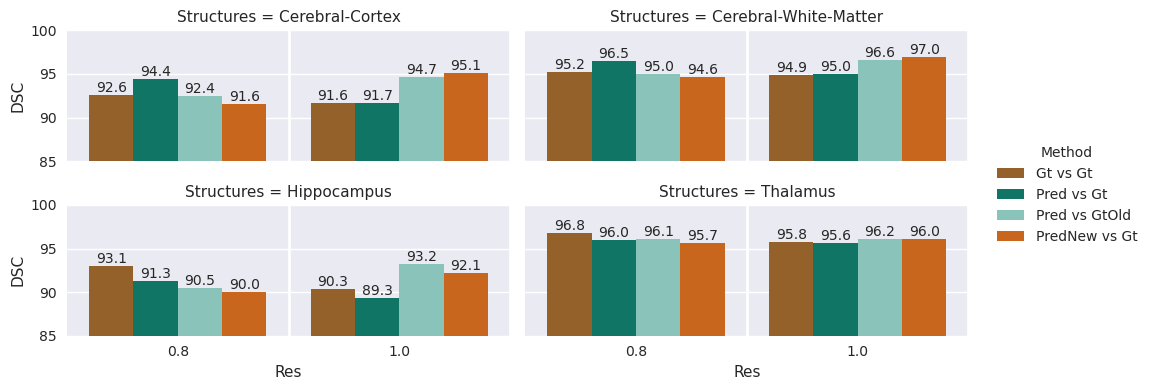

In [756]:
pal1 = ["#a6611a",  "#018571",  "#80cdc1", "#e66101", "#fdb863", "#5e3c99", "#b2abd2" ]
pal2 = ["#deebf7", "#3182bd",  # "#9ecae1", #
        "#fee6ce", "#e6550d", # "#fdae6b", #
        "#f0f0f0", "#bdbdbd", "#636363"]

melted["Combi"] = melted["Res"].astype(str) + "_" + melted["Method"]

filternet= (melted["Structures"].isin(["Cerebral-Cortex", "Subcortical", "Cerebral-White-Matter", "Hippocampus", "Thalamus"]))


boxp = sns.catplot(data=melted[filternet], x="Res", y="DSC", 
                   hue="Method", col="Structures", col_wrap=2,
                   palette=pal1,
                   #hue_order=["05", "57", "575",
                   #          "08", "08R", "59",
                   #          "10"],
                   #col_wrap=5, #hue_order=net_sel,
                   kind="bar", legend_out=True, height=2, aspect=2.5)
boxp.set(ylim=(85, 100))
#boxp.set_xticklabels(rotation=30)
for line in [0.5, 1.5]:#, 2.5]:#, 3.5]:#, 4.5]:
    boxp.refline(x=line, color = "white", lw = 2, linestyle='-')
    
for ax in boxp.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height()):.1f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

In [625]:
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from skimage import color
from SuperResSurfer.SuperResSegm.utils import colormapper as col
rgb_lut = lut[["R", "G", "B"]].values /256

n_bins = lut["ID"].values  # Discretizes the interpolation into bins
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, rgb_lut, N=89)
cl = ListedColormap(rgb_lut, name='from_list', N=89)

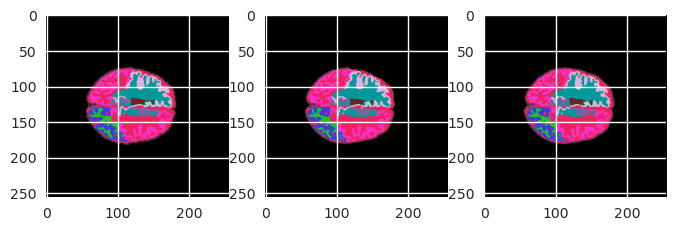

In [673]:
fig, ax = plt.subplots(2, 3)
reorient_eight_m = color.label2rgb(reorient_eight, bg_label=0, colors=rgb_lut)
sbj_eight_m = color.label2rgb(sbj_eight, bg_label=0, colors=rgb_lut)
pred_cnn_eight_m = color.label2rgb(pred_cnn_eight, bg_label=0, colors=rgb_lut)
ax[0, 0].imshow(reorient_eight_m[:, 100, :])
ax[0, 1].imshow(sbj_eight_m[:, 100, :])
ax[0, 2].imshow(pred_cnn_eight_m[:, 100, :])

reorient_one_m = color.label2rgb(reorient_one, bg_label=0, colors=rgb_lut)
sbj_one_m = color.label2rgb(sbj_one, bg_label=0, colors=rgb_lut)
pred_cnn_one_m = color.label2rgb(pred_cnn_one, bg_label=0, colors=rgb_lut)
ax[1, 0].imshow(reorient_one_m[:, 100, :])
ax[1, 1].imshow(sbj_one_m[:, 100, :])
ax[1, 2].imshow(pred_cnn_one_m[:, 100, :])



In [328]:
# Plot intensity histograms
import nibabel as nib
import matplotlib.pyplot as plt
sbj_dir = "/projects/datasets/dHCP/Data/sub-CC00189XX17_ses-62301/"
t2w_08 = nib.load(sbj_dir + "T2w_08_dhcp.nii.gz").get_fdata()
t2w_08b = nib.load(sbj_dir + "T2w_08_dhcp_orig.nii.gz").get_fdata()
t2w_10 = nib.load(sbj_dir + "T2w.nii.gz").get_fdata()
t2w_05 = nib.load(sbj_dir + "T2w_min.nii.gz").get_fdata()

Res: 08, max: 255.0, min: 0.0, mean: 5.400284647941589, median: 0.0
Res: 08b, max: 238.0, min: 0.0, mean: 5.751858472824097, median: 0.0
Res: 10, max: 255.0, min: 0.0, mean: 2.7587709426879883, median: 0.0
Res: 05, max: 255.0, min: 0.0, mean: 15.21639944237156, median: 0.0


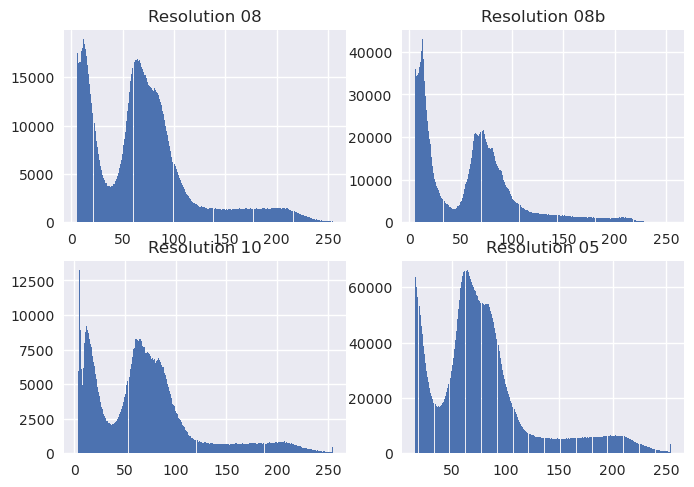

In [337]:
fig, ax = plt.subplots(2, 2)
for i, j, res, img in zip([0, 0, 1, 1], [0, 1, 0, 1], ["08", "08b", "10", "05"], [t2w_08, t2w_08b, t2w_10, t2w_05]):
    print(f"Res: {res}, max: {np.max(img)}, min: {np.min(img)}, mean: {np.mean(img)}, median: {np.median(img)}")
    ax[i, j].hist(img.flatten(), bins=256, range=(np.mean(img), 255))
    ax[i, j].set_title(f"Resolution {res}")

Res: 08, max: 1.0, min: 0.0, mean: 0.021177586854672876, median: 0.0
Res: 08b, max: 0.9333333333333333, min: 0.0, mean: 0.022556307736565057, median: 0.0
Res: 10, max: 1.0, min: 0.0, mean: 0.010818709579168584, median: 0.0
Res: 05, max: 1.0, min: 0.0, mean: 0.05967215467596685, median: 0.0


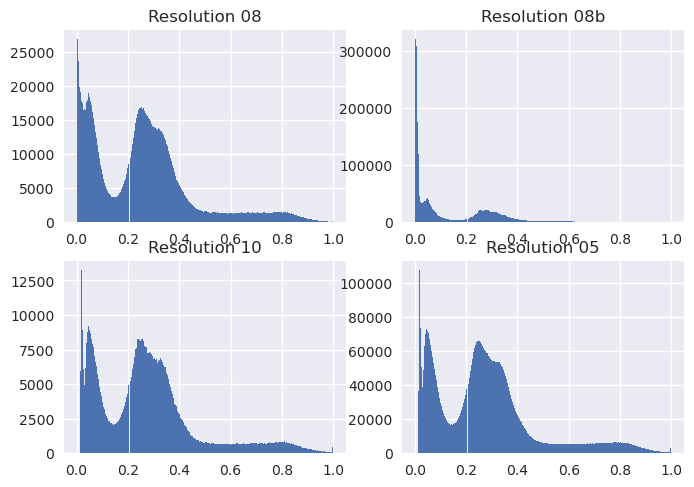

In [331]:
fig, ax = plt.subplots(2, 2)
for i, j, res, img in zip([0, 0, 1, 1], [0, 1, 0, 1], ["08", "08b", "10", "05"], [t2w_08, t2w_08b, t2w_10, t2w_05]):
    img = np.clip(img / 255.0, a_min=0.0, a_max=1.0)
    print(f"Res: {res}, max: {np.max(img)}, min: {np.min(img)}, mean: {np.mean(img)}, median: {np.median(img)}")
    ax[i, j].hist(img.flatten(), bins=256, range=(0.001, 1))
    ax[i, j].set_title(f"Resolution {res}")

In [333]:
import sys
sys.path.append("/projects/DeepSurfer/FastSurfer")
sys.path.append("/projects/DeepSurfer/FastSurfer/FastSurfer")

import FastSurfer.FastSurferCNN.data_loader.conform as conf

def rescale(img_data):
    src_min, scale = conf.getscale(img_data, 0, 255)
    img = conf.scalecrop(img_data, 0, 255, src_min, scale)
    return np.uint8(np.rint(img))

Input:    min: 0.0  max: 255.0
rescale:  min: 0.0  max: 244.54500000000002  scale: 1.0427528675703857
Output:   min: 0.0  max: 255.0
Res: 08, max: 255, min: 0, mean: 5.630796194076538, median: 0.0
Input:    min: 0.0  max: 238.0
rescale:  min: 0.0  max: 219.67399999999998  scale: 1.1608110199659496
Output:   min: 0.0  max: 255.0
Res: 08b, max: 255, min: 0, mean: 6.664450824260712, median: 0.0
Input:    min: 0.0  max: 255.0
rescale:  min: 0.0  max: 250.665  scale: 1.017293997965412
Output:   min: 0.0  max: 255.0
Res: 10, max: 255, min: 0, mean: 2.80381441116333, median: 0.0
Input:    min: 0.0  max: 255.0
rescale:  min: 0.0  max: 251.685  scale: 1.0131712259371835
Output:   min: 0.0  max: 255.0
Res: 05, max: 255, min: 0, mean: 15.409873057525934, median: 0.0


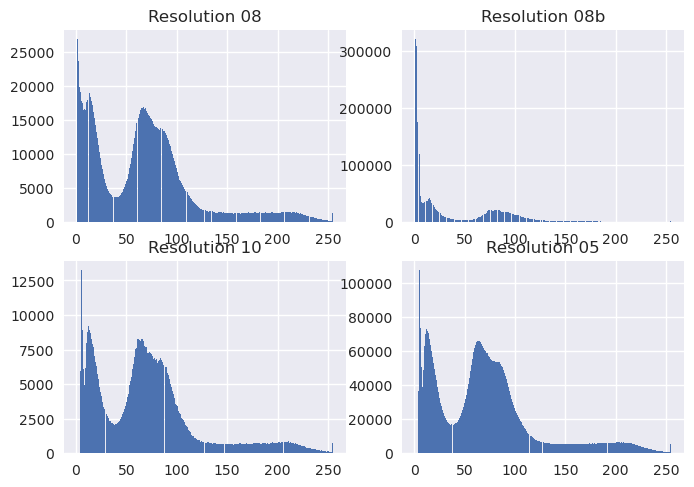

In [335]:
fig, ax = plt.subplots(2, 2)
for i, j, res, img in zip([0, 0, 1, 1], [0, 1, 0, 1], ["08", "08b", "10", "05"], [t2w_08, t2w_08b, t2w_10, t2w_05]):
    img = rescale(img)
    print(f"Res: {res}, max: {np.max(img)}, min: {np.min(img)}, mean: {np.mean(img)}, median: {np.median(img)}")
    ax[i, j].hist(img.flatten(), bins=256, range=(1, 255))
    ax[i, j].set_title(f"Resolution {res}")

In [95]:
np.unique(dsc_df["LabelSet"])
#dsc_df[filternet].head()
#"#feedde", "#fdd0a2", "#fdae6b", "#fd8d3c",  "#9ecae1",
# (dsc_df["Net"].isin(["FastSurferCNN", "FastSurferVINN"])) &    
dsc_df["Combi"] = dsc_df["Net"] + " " + dsc_df["Aug"]
dsc_df[dsc_df["Net"] == "nnUNet"].head()
dsc_df[(dsc_df["NetOnPredMode"] == "T1 on T1")]

,SubjectName,Net_type,Structures,SF,dice,Res,Net,NetMode,Aug,Mode,NetOnPredMode,LabelSet,Combi
0,sub-CC00051XX02_ses-7702,FS_NoAug_T1,Amygdala,1.0,69.986281,10,FS,T1,NoAug,T1,T1 on T1,Mapped,FS NoAug
1,sub-CC00051XX02_ses-7702,FS_NoAug_T1,Average,1.0,64.330592,10,FS,T1,NoAug,T1,T1 on T1,Mapped,FS NoAug
2,sub-CC00051XX02_ses-7702,FS_NoAug_T1,Cerebellum,1.0,77.175168,10,FS,T1,NoAug,T1,T1 on T1,Mapped,FS NoAug
3,sub-CC00051XX02_ses-7702,FS_NoAug_T1,Cerebral-Cortex,1.0,63.569195,10,FS,T1,NoAug,T1,T1 on T1,Mapped,FS NoAug
4,sub-CC00051XX02_ses-7702,FS_NoAug_T1,Cerebral-White-Matter,1.0,40.931343,10,FS,T1,NoAug,T1,T1 on T1,Mapped,FS NoAug
...,...,...,...,...,...,...,...,...,...,...,...,...,...
152870,sub-CC01234AN14_ses-155030,FastSurferVINN_LatentAug_T1,Superior_temporal_gyrus_posterior_part_GM,1.0,79.205374,10,FastSurferVINN,T1,LatentAug,T1,T1 on T1,Full,FastSurferVINN LatentAug
152871,sub-CC01234AN14_ses-155030,FastSurferVINN_LatentAug_T1,Superior_temporal_gyrus_posterior_part_WM,1.0,85.248367,10,FastSurferVINN,T1,LatentAug,T1,T1 on T1,Full,FastSurferVINN LatentAug
152872,sub-CC01234AN14_ses-155030,FastSurferVINN_LatentAug_T1,Thalamus,1.0,93.893477,10,FastSurferVINN,T1,LatentAug,T1,T1 on T1,Full,FastSurferVINN LatentAug
152873,sub-CC01234AN14_ses-155030,FastSurferVINN_LatentAug_T1,Thalamus_high_intensity_part_in_T2,1.0,92.544496,10,FastSurferVINN,T1,LatentAug,T1,T1 on T1,Full,FastSurferVINN LatentAug


In [122]:
boxp = sns.catplot(data=dsc_df[filternet], x="Res", y="dice", 
                   hue="Combi", col="Structures", #row="Net",
                   palette=["#a6611a", "#dfc27d", "#018571",  "#80cdc1", 
                           "#e66101", "#fdb863", "#5e3c99", "#b2abd2", ],
                   hue_order=["FS NoAug", "FastSurferCNN RotTLScale", "FastSurferVINN LatentAug"],
                   #col_wrap=5, #hue_order=net_sel,
                   kind="box", legend_out=True, height=5, aspect=0.8)
boxp.set(ylim=(0, 100))

ValueError: Could not interpret input 'Combi'

In [107]:
filternet = (dsc_df["Net"].isin(["nnUNet", "FastSurferCNN", "FastSurferVINN"])) & (dsc_df["NetOnPredMode"].isin(["T2 on T2", "T1T2 on T2"])) & (dsc_df["Res"] != "08")  & (dsc_df["Structures"].isin(["Average", "Cerebral-Cortex", "Subcortical", "Cerebral-White-Matter", "Hippocampus", "Amygdala"])) & (dsc_df["LabelSet"] == "Full") 
#   .isin(["T1 on T1", "T2 on T2", "T1T2 on T1", "T1T2 on T2"])
# & (dsc_df["Aug"] == "NoAug")
#  (dsc_df["Net"] == "FastSurferVINN") &  , 
# ["Hippocampus", "Amygdala", "Cerebral-Cortex", "Cerebral-White-Matter", "Cerebellum"]
# (dsc_df["NetOnPredMode"] == "T2 on T2") &  ["Average", "Cerebral-Cortex", "Subcortical", "Cerebral-White-Matter"]
fig = px.box(dsc_df[filternet], x="Res", y=metric, color="Net", 
       hover_data=["SubjectName"], 
       category_orders={"Net_type": net_sel}, 
       facet_col="Structures",facet_row="NetOnPredMode",#OnPredMode", 
       color_discrete_sequence=["#a6611a", "#dfc27d", "#80cdc1", "#018571"])

fig.update_layout(showlegend=True, legend=dict(
    yanchor="bottom",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_xaxes(categoryorder='array', categoryarray= ["Average", "Cerebral-Cortex", "Cerebral-White-Matter", "Subcortical"], tickangle=90)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1])) 
fig.show()


In [30]:
np.unique(dsc_df["LabelSet"])

KeyError: 'LabelSet'

In [36]:
dsc_df.columns

Index(['SubjectName', 'Net_type', 'Structures', 'SF', 'dice', 'Res', 'BaseRes',
       'Net', 'NetMode', 'Aug', 'Mode', 'NetOnPredMode'],
      dtype='object')

In [61]:
boxp.savefig(based + "/FastInfantSurfer/plotting_debug/all_classes_full.svg")

In [ ]:
np.unique(dsc_df["Net_type"])

In [ ]:
per_run_combi = dsc_df[["Sel", "SF", "Structures", "Mode", 
                        "Aug", "dice"]].groupby(["Sel", "SF", "Mode", "Aug", "Structures"]).agg("median")

In [ ]:
per_run_combi_reset = per_run_combi.reset_index()

In [ ]:
pivot_result = per_run_combi_reset.pivot(index=["SF", "Structures"], columns=["Sel", "Mode", "Aug"])

In [ ]:
pivot_result

In [ ]:
pivot_result.to_csv(base_dir + "/metric_overview/vinn_ddb_comparison.tsv", sep="\t")

In [ ]:
# Get difference between VINN and DDB
ddb = (per_run_combi_reset["Sel"] == "FastSurferDDB_1.0BR")
vinn5 = (per_run_combi_reset["Sel"] == "FastSurferVINN_0.5BR")
vinn8 = (per_run_combi_reset["Sel"] == "FastSurferVINN_0.8BR")

no_aug = (per_run_combi_reset["Aug"] == "NoAug")
artefact = (per_run_combi_reset["Aug"] == "ScaleArtefact")

sf5 = (per_run_combi_reset["SF"] == 0.5)
sf8 = (per_run_combi_reset["SF"] == 0.8)
sf1 = (per_run_combi_reset["SF"] == 1.0)
# Get difference between Augs in VINN and DDB
per_run_combi_reset[ddb & artefact & sf1]

# Vinn versus DDB
per_run_combi_reset[ddb].set_index(['Structures', 'Mode', 'Aug']).subtract(per_run_combi_reset[vinn5].set_index(['Structures', 'Mode', 'Aug']), fill_value=0)
#per_run_combi_reset[ddb].reset_index(drop=True) - per_run_combi_reset[vinn5].reset_index(drop=True)

In [ ]:
base_dir = "/autofs/vast/lzgroup/Projects/FastInfantSurfer/experiments/"
metric = "vs"
vs_pattern = f"*_net1/eval_metrics/{metric}_ValSet*[!(coronal)].tsv"

# get dsc_list with one of the methods defined above
fig_vs = plot_metrics(base_dir, metric, pattern=vs_pattern, networks=net_sel)
fig_vs.update_layout(legend=dict(
    yanchor="bottom",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig_vs.update_xaxes(categoryorder='array', categoryarray= ["Average", "Cerebral-Cortex", "Subcortical"])
fig_vs.show()

In [ ]:
base_dir = "/autofs/vast/lzgroup/Projects/FastInfantSurfer/experiments/"
metric = "surfaceAverageHausdorff"
asd_pattern = f"*_net1/eval_metrics/{metric}_ValSet*[!(coronal)].tsv"
#net_sel = ["FastSurferVINN-dHCP-NoAug", "FastSurferVINN-dHCP-LatentAug", "FastSurferDDB-dHCP-Test", "RCVNet-dHCP-LatentAug"]

# get dsc_list with one of the methods defined above
fig_asd = plot_metrics(base_dir, metric, pattern=asd_pattern, networks=net_sel)
fig_asd.update_layout(showlegend=False, legend=dict(
    yanchor="bottom",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig_asd.update_xaxes(categoryorder='array', categoryarray= ["Average", "Cerebral-Cortex", "Subcortical"])
fig_asd.update_yaxes(range=[0,1])
fig_asd.show()


In [ ]:
# Join Validation list with meta information
# and plot age-group dependent values

# load meta info
meta = pd.read_csv("/autofs/vast/lzgroup/Users/LeonieHenschel/FastInfantSurfer/data/subject_meta_to_assign.csv", sep=",")
meta["SubjectName"] = meta.agg('sub-{0[participant_id]}_ses-{0[session_id]}'.format, axis=1)

# Join dsc-dataframe with meta info
combi = pd.merge(dsc_df, meta, how="left", on="SubjectName")
combi.head()


In [ ]:
# Get Age distribution
combi["scan_age"].hist()

conditions = [(combi["scan_age"] <= 35), 
              (combi["scan_age"] >35) & (combi["scan_age"] <= 40), 
              (combi["scan_age"] > 40)]
     
values = ["< 35 weeks", "35-40 weeks", "> 40 weeks"]

combi["q_scan_age"] = np.select(conditions, values)
#pd.qcut(combi["scan_age"], 3, labels=False) 


In [ ]:
metaold = pd.read_csv("/autofs/vast/lzgroup/Users/LeonieHenschel/FastInfantSurfer/data/subject_meta_assigned.csv", sep=",")
metaold["SubjectName"] = metaold.agg('sub-{0[participant_id]}_ses-{0[session_id]}'.format, axis=1)
metaold["scan_age"].loc[metaold["Set"] == "Validation"].hist()

In [ ]:
training = pd.read_csv("/autofs/vast/lzgroup/Users/LeonieHenschel/FastInfantSurfer/data/dataset_split_large_validation_t1t2.csv", names=["Subject"])
training["SubjectName"] = training["Subject"].apply(lambda x: x.split("/")[-1])
training.head()

# Join training-dataframe with meta info
train_combi = pd.merge(training, meta, how="left", on="SubjectName")

# Get Age distribution
train_combi["scan_age"].hist()


In [ ]:
# Join Validation list with meta information
# and plot age-group dependent values

# Join dsc-dataframe with meta info
combi = pd.merge(dsc_df, metaold, how="left", on="SubjectName")

# Get Age distribution
combi["scan_age"].hist()

conditions = [(combi["scan_age"] <= 42.5), 
              (combi["scan_age"] > 42.5)]
     
values = ["< 43 weeks", "> 43 weeks"]

combi["q_scan_age"] = np.select(conditions, values)
#pd.qcut(combi["scan_age"], 3, labels=False) 

In [ ]:
measure="dice"
networks=net_sel
px.box(combi, x="Structures", y=measure, color="Net_type", facet_row="q_scan_age", hover_data=["SubjectName"], 
                  category_orders={"Net_type": networks, "q_scan_age": values, "Structures": ["Average", "Cerebral-Cortex", "Subcortical"]},
                  color_discrete_sequence=["#543005", "#b2182b",
                                                  "#8c510a","#d6604d", #"#bf812d","#f4a582",
                                                  "#003c30", "#4d4d4d",
                                                  "#01665e","#878787",
                                                  "#35978f", "#bababa"])
#fig.update_layout(showlegend=False)

In [ ]:
# Get list of outliers
# For each column, computes the Z-score, relative to the column mean and standard deviation.
# Then take the absolute Z-score if it is below the threshold.
# all(axis=1) ensures that for each row, all column satisfy the constraint.

# Get IQR and limits from it per Structure
Q1 = dsc_all.groupby("Structures")["DSC"].quantile(0.25)
Q3 = dsc_all.groupby("Structures")["DSC"].quantile(0.75)
IQR = Q3 - Q1
upper_lim = Q3 + 1.5 * IQR
lower_lim = Q1 - 1.5 * IQR

# join upper and lower lim to dataframe
dsc_all['LowerLim'] = dsc_all["Structures"].map(lower_lim)
dsc_all['UpperLim'] = dsc_all["Structures"].map(upper_lim)

# Get outliers
outliers = dsc_all[dsc_all["DSC"] < dsc_all["LowerLim"]]

outliers.to_csv(base + "eval_metrics/dsc_outliers_all.tsv", index=False, 
                columns=["SubjectName", "Net_type", "Structures", "DSC", "LowerLim"], sep="\t")

# Get only subject names (drop duplicates)
outliers["SubjectName"].drop_duplicates().to_csv(base + "eval_metrics/dsc_outliers_subjects.tsv", 
                                                 index=False, sep="\t")


In [ ]:
#dsc_list = glob.glob(base + pattern)
dsc_all = pu.combine_dfs(dsc_list, "DSC", "SF")

In [ ]:
df_final.shape

In [ ]:
#dsc_list = glob.glob(base + pattern)

In [ ]:
dsc_list

In [ ]:
import numpy as np
dsc_all["SF"].fillna('FastSurferVINN_coronal',inplace=True)

In [ ]:
np.unique(dsc_all["SF"])
dsc_all["Net_type"] = dsc_all["SF"].apply(lambda x: "FastSurferCNN" if x == "ValSet_FastSurferCNN_orig_coronal" else "FastSurferVINN")
np.unique(dsc_all["Net_type"])

In [ ]:
df_final.columns
dsc_all = df_final[df_final["Metric"] == "DSC"]
asd_all = df_final[df_final["Metric"] == "ASD"]
vs_all = df_final[df_final["Metric"] == "VS"]

In [ ]:
dsc_all.head()


In [ ]:
fig = px.box(dsc_all, x="Metric", y="Structures", color="Net_type", hover_data=["SubjectName"])
fig.show()

In [ ]:
fig = px.box(dsc_all, x="ASD", y="Structures", color="Net_type", hover_data=["SubjectName"])
fig.show()

In [ ]:
fig = px.box(dsc_all, x="VS", y="Structures", color="Net_type", hover_data=["SubjectName"])
fig.show()